![image.png](attachment:image.png)

# Regressão III - Tarefa

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
# importando a base de dados

df = pd.read_csv('/content/drive/MyDrive/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [177]:
# verificando missings

df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [178]:
# substituindo missings em tempo de emprego pela média

df.loc[df.tempo_emprego.isnull(), 'tempo_emprego'] = df.tempo_emprego.mean()

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [179]:
base_treino = df.loc[df.index.isin(df.index.unique()[-3:]) == False] # separando a base de treino sem os 3 últimos meses

base_teste = df.loc[df.index.isin(df.index.unique()[-3:])] # separando a base de teste com os 3 últimos meses

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [180]:
# definindo as variáveis explicativas do modelo

variaveis_explicativas = 'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

In [181]:
# avaliando o modelo com o R² - ajustado

res1 = smf.ols('renda ~ '+variaveis_explicativas+'', data=base_treino).fit()

print('R² ajustado do modelo: ',res1.rsquared_adj)

R² ajustado do modelo:  0.2449965478623849


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [ ]:
# Criando coluna tempo_emprego categorizada em 20 quantis

base_treino['tempo_emprego_ctg'], quebras = pd.qcut(base_treino.tempo_emprego, 23, duplicates='drop', retbins=True)

In [183]:
# criando coluna para a média do tempo de emprego para cada categoria

media = [base_treino.loc[base_treino.tempo_emprego_ctg == categoria, 'tempo_emprego'].mean() for categoria in base_treino.tempo_emprego_ctg.unique()]

In [ ]:
# criando coluna com valores de log de renda na base treino e na base teste

base_treino['renda_log'] = np.log(base_treino.renda)
base_teste['renda_log'] = np.log(base_teste.renda)

# criando coluna para a média do log-renda para cada categoria

renda_log = [base_treino.loc[base_treino.tempo_emprego_ctg == categoria, 'renda_log'].mean() for categoria in base_treino.tempo_emprego_ctg.unique()]

In [185]:
# armazenando as colunas em um dataframe

base_emprego_quantis = pd.DataFrame(base_treino.tempo_emprego_ctg.value_counts()) # tabela com as categorias e respectiva quantidade
base_emprego_quantis.columns = ['quantidade']

base_emprego_quantis['media'] = media # inserindo coluna da média
base_emprego_quantis['renda_log'] = renda_log # inserindo a coluna da renda_log

In [186]:
base_emprego_quantis.head(3)

,quantidade,media,renda_log
"(7.033, 7.746]",122478,18.606878,10.798668
"(0.737, 1.26]",26854,9.369876,9.544331
"(5.638, 6.384]",26420,8.422697,9.411085


<Axes: xlabel='media', ylabel='renda_log'>

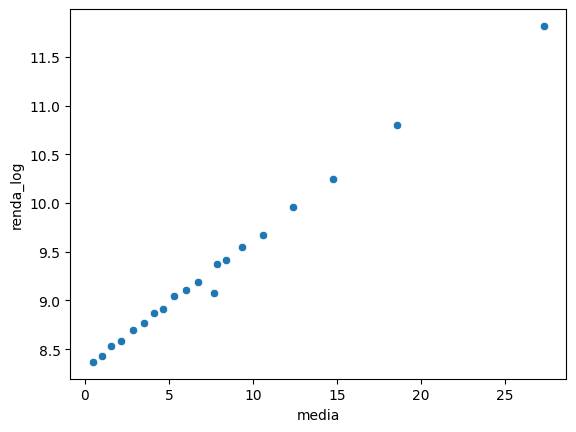

In [187]:
# Fazendo um gráfico da média do tempo de emprego pela média do log-renda

sns.scatterplot(x='media', y='renda_log', data=base_emprego_quantis)

*Verifica-se pelo gráfico acima que há uma forte correlação positiva entre a variável tempo de emprego médio com a variável log da renda*

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


#### *1. Categorização*

In [188]:
# definindo as variáveis explicativas substituindo a variável tempo de emprego por tempo de emprego categorizado

variaveis_explicativas = 'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego_ctg + qt_pessoas_residencia'


In [189]:
# avaliando o modelo com o R² - ajustado

res2 = smf.ols('renda ~ '+variaveis_explicativas+'', data=base_treino).fit()

print('R² ajustado do modelo com categorização: ',res2.rsquared_adj)

R² ajustado do modelo com categorização:  0.25847496115502444


#### *2. Transformação sobre X*

In [190]:
# definindo as variáveis explicativas do modelo substituindo variável tempo de emprego por log de tempo de emprego

variaveis_explicativas = 'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + np.log(tempo_emprego) + qt_pessoas_residencia'

In [191]:
# avaliando o modelo com o R² - ajustado

res3 = smf.ols('renda ~ '+variaveis_explicativas+'', data=base_treino).fit()

print('R² ajustado do modelo com transformação sobre X: ',res3.rsquared_adj)

R² ajustado do modelo com transformação sobre X:  0.10907672269732915


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [192]:
# Avaliando o resultado do primeiro modelo na base de testes

print('R² ajustado do primeiro modelo na base de teste: ', r2_score(y_true=base_treino['renda'], y_pred=res1.predict(base_treino)))

R² ajustado do primeiro modelo na base de teste:  0.24502674805080438


In [193]:
# Avaliando o resultado do segundo modelo  na base de testes

print('R² ajustado do segundo modelo na base de teste: ', r2_score(y_true=base_treino['renda'], y_pred=res2.predict(base_treino)))

R² ajustado do segundo modelo na base de teste:  0.2585268679942544


In [194]:
# Avaliando o resultado do terceiro modelo  na base de testes

print('R² ajustado do terceiro modelo na base de teste: ', r2_score(y_true=base_treino['renda'], y_pred=res3.predict(base_treino)))

R² ajustado do terceiro modelo na base de teste:  0.10911235968781641
